In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import pydicom 
%matplotlib inline

In [3]:
data_dir = Path('../data')

In [4]:
!ls {data_dir} 

rsna-intracranial-hemorrhage-detection.zip  stage_1_train.csv
stage_1_sample_submission.csv		    stage_1_train_images
stage_1_test_images			    stage_1_train_pivot.csv


In [5]:
train_df = pd.read_csv(data_dir / 'stage_1_train.csv')

In [6]:
train_df.head()

,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0
3,ID_63eb1e259_subarachnoid,0
4,ID_63eb1e259_subdural,0


In [7]:
train_df['filename'] = train_df['ID'].apply(lambda st: "ID_" + st.split('_')[1])# + ".png")
train_df['type'] = train_df['ID'].apply(lambda st: st.split('_')[2])

In [8]:
print(train_df.shape)
train_df.head()

(4045572, 4)


,ID,Label,filename,type
0,ID_63eb1e259_epidural,0,ID_63eb1e259,epidural
1,ID_63eb1e259_intraparenchymal,0,ID_63eb1e259,intraparenchymal
2,ID_63eb1e259_intraventricular,0,ID_63eb1e259,intraventricular
3,ID_63eb1e259_subarachnoid,0,ID_63eb1e259,subarachnoid
4,ID_63eb1e259_subdural,0,ID_63eb1e259,subdural


In [9]:
4045572 - 4045548 # 24 duplicates present in train_df

24

In [10]:
pivot_df = train_df[['Label', 'filename', 'type']].drop_duplicates().pivot(index='filename', columns='type', values='Label').reset_index()
print(pivot_df.shape)
pivot_df.head()

(674258, 7)


type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000039fa0,0,0,0,0,0,0
1,ID_00005679d,0,0,0,0,0,0
2,ID_00008ce3c,0,0,0,0,0,0
3,ID_0000950d7,0,0,0,0,0,0
4,ID_0000aee4b,0,0,0,0,0,0


In [13]:
# pivot_df.to_feather('../data/stage_1_train_pivot.feather')

In [14]:
test_df = pd.read_feather('../data/stage_1_train_pivot.feather')

In [20]:
test_df = pd.read_csv('../data/stage_1_train_pivot.csv')

In [21]:
test_df.head()

,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000039fa0,0,0,0,0,0,0
1,ID_00005679d,0,0,0,0,0,0
2,ID_00008ce3c,0,0,0,0,0,0
3,ID_0000950d7,0,0,0,0,0,0
4,ID_0000aee4b,0,0,0,0,0,0


In [27]:
# pivot_df.to_csv('../data/stage_1_train_pivot.csv', index=False)

In [32]:
pivot_df.iloc[10].values[1:]

array([0, 0, 0, 0, 0, 0], dtype=object)

In [14]:
train_df['image'] = train_df['ID'].str.slice(stop=12)
train_df['diagnosis'] = train_df['ID'].str.slice(start=13)

train_df.head()

,ID,Label,filename,type,image,diagnosis
0,ID_63eb1e259_epidural,0,ID_63eb1e259.png,epidural,ID_63eb1e259,epidural
1,ID_63eb1e259_intraparenchymal,0,ID_63eb1e259.png,intraparenchymal,ID_63eb1e259,intraparenchymal
2,ID_63eb1e259_intraventricular,0,ID_63eb1e259.png,intraventricular,ID_63eb1e259,intraventricular
3,ID_63eb1e259_subarachnoid,0,ID_63eb1e259.png,subarachnoid,ID_63eb1e259,subarachnoid
4,ID_63eb1e259_subdural,0,ID_63eb1e259.png,subdural,ID_63eb1e259,subdural


### Windowing

In [15]:
window_center = 40
window_width = 80
def window_and_normalize(im):
    rescaled = im.pixel_array * float(im.RescaleSlope) + float(im.RescaleIntercept)
    windowed = rescaled.clip(min=window_center-window_width, max=window_center+window_width)

    return (windowed + np.negative(window_center-window_width)) / (window_width * 2 * 1/255)

In [16]:
path = data_dir / 'stage_1_train_images/ID_000039fa0.dcm' 
org_im = pydicom.read_file(str(path))
im = window_and_normalize(org_im)

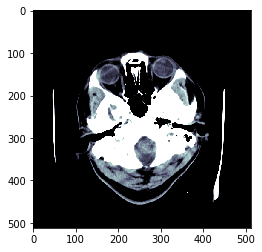

In [17]:
plt.imshow(im, cmap=plt.cm.bone)

In [18]:
im.min(), im.max()

(0.0, 255.0)

In [19]:
iimg = org_im.pixel_array
np.unique(iimg), iimg.dtype, im.dtype

(array([-2000,     0,     1, ...,  2834,  2836,  2848], dtype=int16),
 dtype('int16'),
 dtype('float64'))

In [20]:
512* pivot_df.shape[0] / 1000000 # 345 GB of data storage

345.220096

In [21]:
pivot_df.shape

(674258, 7)

In [22]:
im32 = im.astype('float32')

In [106]:
np.save('test.npy', iimg) # 516K
np.save('testim.npy', im) # float64, 2.1M
np.save('testim32.npy', im32) # float32, 1.1M
# float16 you loose precision

In [33]:
def window_image(img, window_center,window_width, intercept, slope, rescale=True):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    
    if rescale:
        # Extra rescaling to 0-1, not in the original notebook
        img = (img - img_min) / (img_max - img_min)
    
    return img
    
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

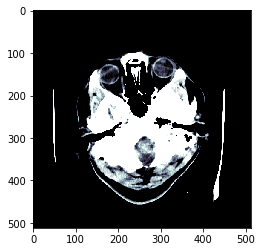

In [34]:
dcm = pydicom.dcmread(str(path))
window_center , window_width, intercept, slope = get_windowing(dcm)
img = dcm.pixel_array
img = window_image(img, window_center, window_width, intercept, slope)
plt.imshow(img, cmap='bone')

In [35]:
img.min(), img.max(), img.shape

(0.0, 1.0, (512, 512))

In [85]:
np.unique(im)

array([  0.     ,   1.59375,   3.1875 ,   4.78125,   6.375  ,   7.96875,
         9.5625 ,  11.15625,  12.75   ,  14.34375,  15.9375 ,  17.53125,
        19.125  ,  20.71875,  22.3125 ,  23.90625,  25.5    ,  27.09375,
        28.6875 ,  30.28125,  31.875  ,  33.46875,  35.0625 ,  36.65625,
        38.25   ,  39.84375,  41.4375 ,  43.03125,  44.625  ,  46.21875,
        47.8125 ,  49.40625,  51.     ,  52.59375,  54.1875 ,  55.78125,
        57.375  ,  58.96875,  60.5625 ,  62.15625,  63.75   ,  65.34375,
        66.9375 ,  68.53125,  70.125  ,  71.71875,  73.3125 ,  74.90625,
        76.5    ,  78.09375,  79.6875 ,  81.28125,  82.875  ,  84.46875,
        86.0625 ,  87.65625,  89.25   ,  90.84375,  92.4375 ,  94.03125,
        95.625  ,  97.21875,  98.8125 , 100.40625, 102.     , 103.59375,
       105.1875 , 106.78125, 108.375  , 109.96875, 111.5625 , 113.15625,
       114.75   , 116.34375, 117.9375 , 119.53125, 121.125  , 122.71875,
       124.3125 , 125.90625, 127.5    , 129.09375, 

In [32]:


def save_and_resize(filenames, load_dir):    
    save_dir = '/kaggle/tmp/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for filename in tqdm(filenames):
        path = load_dir + filename
        new_path = save_dir + filename.replace('.dcm', '.png')
        
        dcm = pydicom.dcmread(path)
        window_center , window_width, intercept, slope = get_windowing(dcm)
        img = dcm.pixel_array
        img = window_image(img, window_center, window_width, intercept, slope)
        
        resized = cv2.resize(img, (224, 224))
        res = cv2.imwrite(new_path, resized)



In [17]:
#train_df = pd.read_csv(BASE_PATH + 'stage_1_train.csv')
#sub_df = pd.read_csv(BASE_PATH + 'stage_1_sample_submission.csv')


#sub_df['filename'] = sub_df['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
#sub_df['type'] = sub_df['ID'].apply(lambda st: st.split('_')[2])


In [43]:
TRAIN_IMG_PATH = data_dir / 'stage_1_train_images'
TEST_IMG_PATH = data_dir / "tage_1_test_images/"

def view_images(images, title = '', aug = None):
    width = 5
    height = 2
    fig, axs = plt.subplots(height, width, figsize=(15,5))
    
    for im in range(0, height * width):
        data = pydicom.read_file(str(TRAIN_IMG_PATH / f'{images[im]}.dcm'))
        image = data.pixel_array
        window_center , window_width, intercept, slope = get_windowing(data)
        image_windowed = window_image(image, window_center, window_width, intercept, slope)


        i = im // width
        j = im % width
        axs[i,j].imshow(image_windowed, cmap=plt.cm.bone) 
        axs[i,j].axis('off')
        
    plt.suptitle(title)
    plt.show()

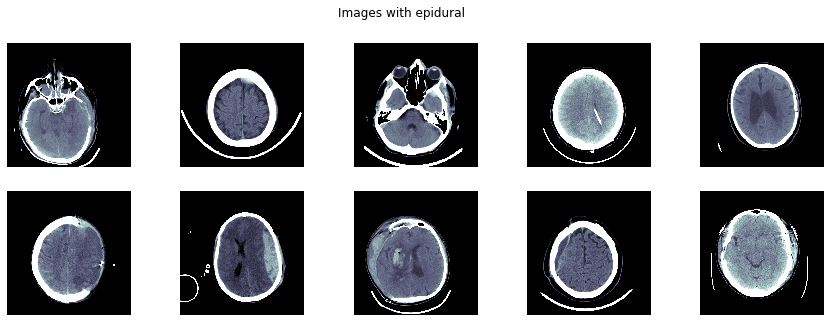

In [44]:
view_images(train_df[(train_df['diagnosis'] == 'epidural') & (train_df['Label'] == 1)][:10].image.values, title = 'Images with epidural')

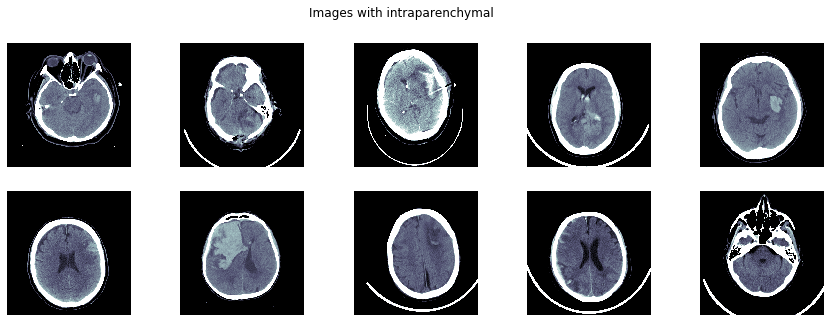

In [45]:
view_images(train_df[(train_df['diagnosis'] == 'intraparenchymal') & (train_df['Label'] == 1)][:10].image.values, title = 'Images with intraparenchymal')

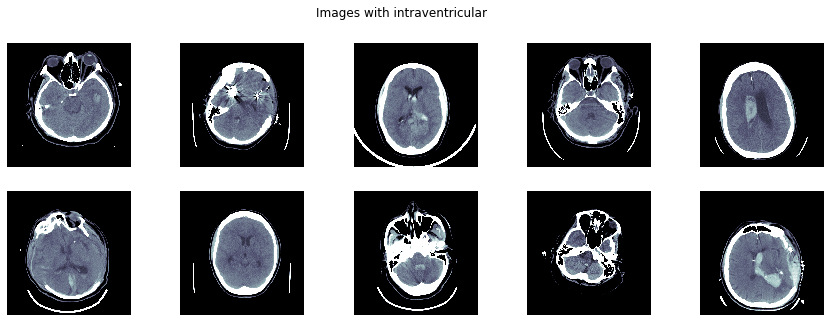

In [55]:
view_images(train_df[(train_df['diagnosis'] == 'intraventricular')& (train_df['Label'] == 1)][:10].image.values, title = 'Images with intraventricular')

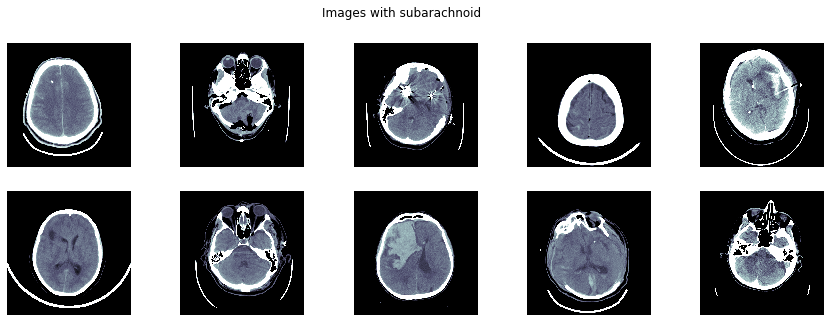

In [56]:
view_images(train_df[(train_df['diagnosis'] == 'subarachnoid')& (train_df['Label'] == 1)][:10].image.values, title = 'Images with subarachnoid')

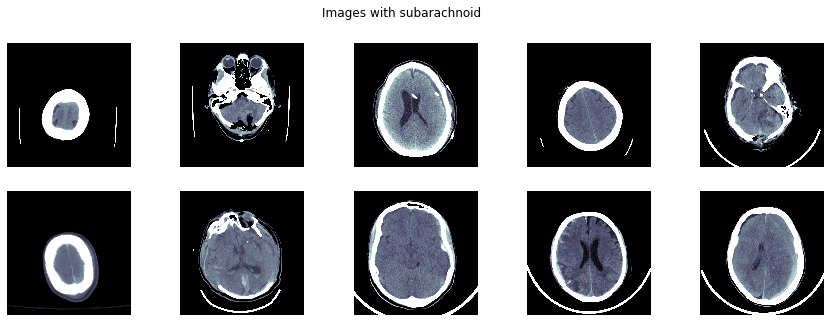

In [57]:
view_images(train_df[(train_df['diagnosis'] == 'subdural') & (train_df['Label'] == 1)][:10].image.values, title = 'Images with subarachnoid')